## Import

In [16]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

torch.__version__

'1.13.1+cpu'

In [2]:
pytorch_workflow = {10:'data (prepare and load))', 
                    20:'model (define and initialize)', 
                    21:'loss (define and initialize)', 
                    22:'optimizer (define and initialize)', 
                    30:'Fit the model', 
                    40:'evaluation (compute loss and accuracy)', 
                    50:'Improve the model (hyperparameter tuning)', 
                    60:'Save and load the model', 
                    70:'Save and reload the model', 
                    80:'Inference (predict on new data)'}

## 10. Data (prepare and load)

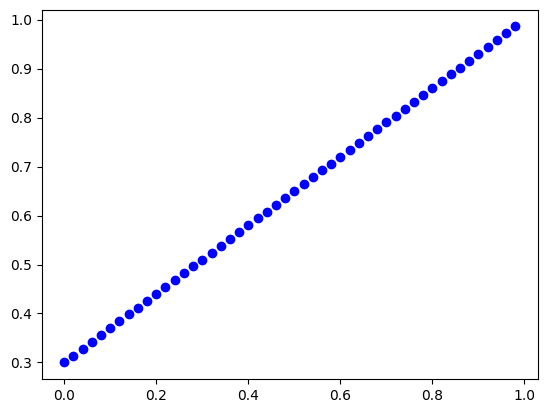

In [17]:
#Known parameters
weight = 0.7 #slope
bias = 0.3 #intercept

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step)
y = weight * X + bias
plt.plot(X, y, 'bo')

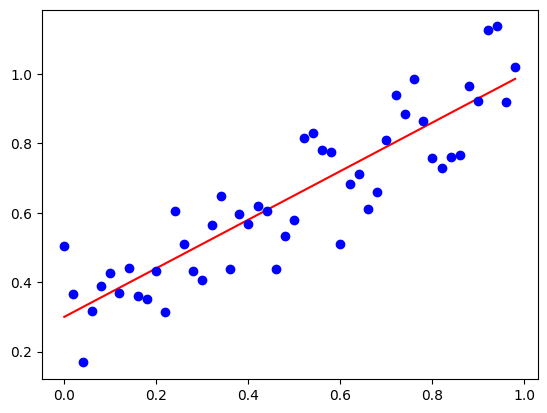

In [13]:
## Add noise
noise = torch.randn(y.shape) * 0.1
y1 = y + noise
plt.plot(X, y, 'r-')
plt.plot(X, y1, 'bo')

In [18]:
# Create train and test data
train_split = int(0.8*len(X))
X_train,y_train = X[:train_split], y[:train_split]
X_test,y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

In [ ]:
#Left off at 04:46